# Weather housing analysis notebook

This notebook is designed to load two data sets into memory and use the data to answer a few questions: 

1. What cities in the united states have weather similar to San Diego? (Dry heat, similar seasonal temperatures, etc) 
2. What are the housing prices like in those similar cities? More expensive? Less expensive? 

Data Sources: 
1. [Kaggle - Historical Hourly Weather Data 2012-2017](https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=wind_speed.csv)



In [1]:
from pathlib import Path 
import pathlib
from enum import Enum
from typing import Dict

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use("fivethirtyeight")
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import plotly.express as px

import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot

In [2]:
ABSPATH_TO_NOTEBOOK: Path = pathlib.Path().absolute()
ABSPATH_TO_DATA: Path = ABSPATH_TO_NOTEBOOK / 'data'
    
time_mapper: Dict[str, str] = {
    'monthly': 'M',
    'weekly': 'W',
    'daily': 'D'
}

### Load weather data for the United States

Weather data includes the following features: 

* Temperature
* Humidity
* Air pressure
* Weather description ("scattered clouds", "light rain", etc.) 
* Wind speed 

In [3]:
## todo - read the files directly from S3 instead of loading from disk

In [4]:
class weather_data:

    weather_metrics = ['temperature', 'humidity', 'pressure', 'wind_speed']
    
    def __init__(self, data_path: Path, time_frequency: str):
        self.data_path = data_path
        self.time_frequency = time_frequency
        self.temperature = self.load_csv(fname=self.weather_metrics[0])
        self.humidity = self.load_csv(fname=self.weather_metrics[1])
        self.air_pressure = self.load_csv(fname=self.weather_metrics[2])
        self.wind_speed = self.load_csv(fname=self.weather_metrics[3])

    def load_csv(self, fname: str):
        fname+='.csv'
        full_path: Path = self.data_path / fname
        df = pd.read_csv(full_path, sep=',')
        df.index = pd.to_datetime(df['datetime'],format='%Y/%m/%d %H:%M:%S')
        # aggregate monthly instead of hourly 
        df = df.groupby(pd.Grouper(freq=self.time_frequency)).transform(np.mean).drop_duplicates()
        # remove non-US columns
        df = df.iloc[:, :-6]
        return df
    
    def __repr__(self):
        return '\n'.join([
        f'Total cities: {self.temperature.shape[1]}',
        f'Total number of monthly weather samples: {self.temperature.shape[0]}',
        f'Weather metrics imported: {self.weather_metrics}'
        ])
    

In [5]:
%%time
wd = weather_data(data_path=ABSPATH_TO_DATA, time_frequency=time_mapper['weekly'])
wd

CPU times: user 10.7 s, sys: 217 ms, total: 10.9 s
Wall time: 11 s


Total cities: 30
Total number of monthly weather samples: 270
Weather metrics imported: ['temperature', 'humidity', 'pressure', 'wind_speed']

In [6]:
wd.temperature.head()

Vancouver    Portland  San Francisco     Seattle  \
datetime                                                                 
2012-10-01 12:00:00  285.008019  287.436972     292.404145  285.364647   
2012-10-08 00:00:00  284.720833  285.642262     288.176220  286.034792   
2012-10-15 00:00:00  283.916726  285.731905     291.387708  285.012708   
2012-10-22 00:00:00  279.670387  281.088631     287.071310  280.389077   
2012-10-29 00:00:00  283.856786  286.729613     288.123899  285.597649   

                     Los Angeles   San Diego   Las Vegas     Phoenix  \
datetime                                                               
2012-10-01 12:00:00   294.643467  294.500153  299.239221  300.877976   
2012-10-08 00:00:00   291.513393  291.938185  293.942500  297.743244   
2012-10-15 00:00:00   294.941369  294.401399  293.943333  297.619315   
2012-10-22 00:00:00   292.391905  291.126429  291.052887  295.278095   
2012-10-29 00:00:00   290.684137  290.443095  290.476280  294.542500   

                     Albuquerque      Denver  ...     Detroit  Jacksonville  \
datetime                                      ...                             
2012-10-01 12:00:00   291.003271  282.981460  ...  287.732209    299.012906   
2012-10-08 00:00:00   286.328452  282.160298  ...  281.436399    295.836548   
2012-10-15 00:00:00   287.568958  285.852232  ...  285.918988    295.522381   
2012-10-22 00:00:00   285.027976  280.840952  ...  287.274018    295.285982   
2012-10-29 00:00:00   284.611756  283.178036  ...  278.627500    289.107619   

                      Charlotte       Miami  Pittsburgh     Toronto  \
datetime                                                              
2012-10-01 12:00:00  292.931562  300.687268  289.019417  287.341592   
2012-10-08 00:00:00  286.585923  299.787589  280.794464  280.671369   
2012-10-15 00:00:00  288.202440  299.697113  285.910982  283.635565   
2012-10-22 00:00:00  289.262500  298.417917  288.503095  284.207708   
2012-10-29 00:00:00  283.365595  293.455744  277.846369  278.926458   

                     Philadelphia    New York    Montreal      Boston  
datetime                                                               
2012-10-01 12:00:00    291.336710  291.751748  287.209794  289.803653  
2012-10-08 00:00:00    283.179583  283.863006  280.680536  283.120714  
2012-10-15 00:00:00    287.110804  287.540119  282.993378  286.240893  
2012-10-22 00:00:00    287.530982  287.641905  282.580521  284.681964  
2012-10-29 00:00:00    282.226012  283.918929  282.975089  284.562946  

[5 rows x 30 columns]

### Visualize city temperatures 

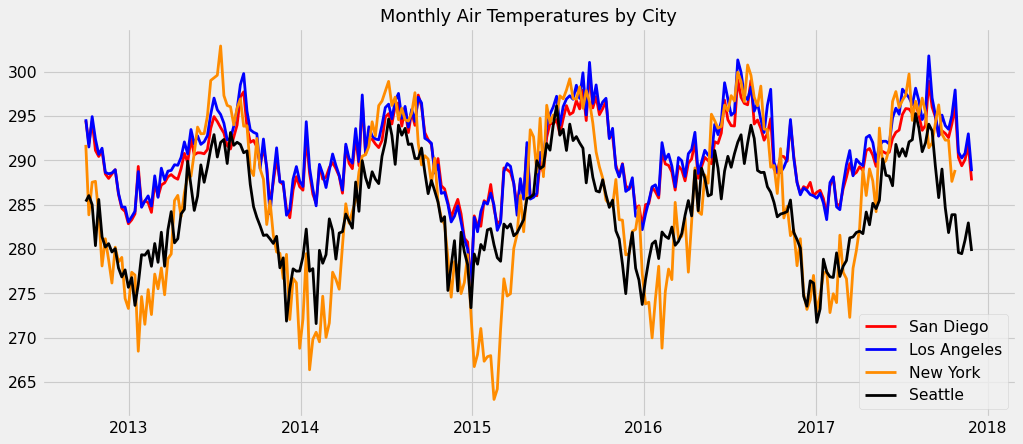

In [7]:
figure(figsize=(14, 6), dpi=80)
plt.plot(wd.temperature.index, wd.temperature['San Diego'], label = "San Diego", linestyle="-", color='red', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Los Angeles'], label = "Los Angeles", linestyle="-", color='blue', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['New York'], label = "New York", linestyle="-", color='darkorange', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Seattle'], label = "Seattle", linestyle="-", color='black', linewidth=2.5)
plt.title('Monthly Air Temperatures by City', fontsize=16)
plt.legend()
plt.show()

### Visualize city humidities 

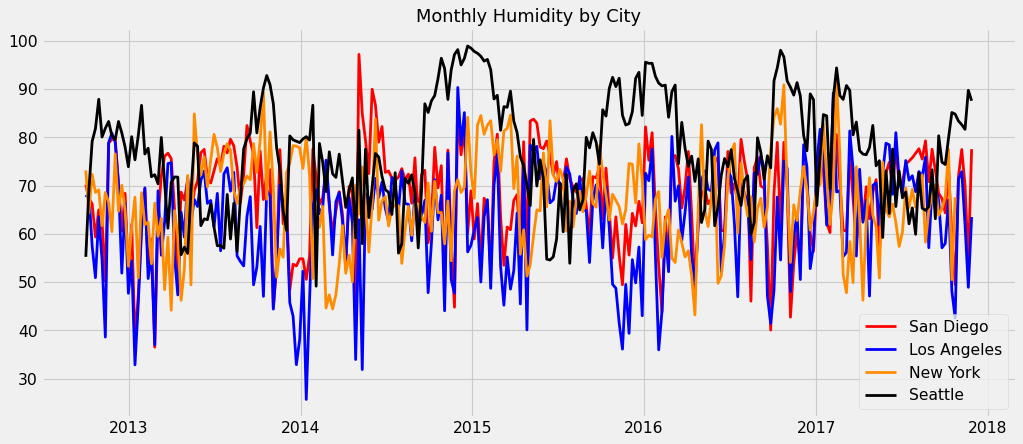

In [8]:
figure(figsize=(14, 6), dpi=80)
plt.plot(wd.humidity.index, wd.humidity['San Diego'], label = "San Diego", linestyle="-", color='red', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['Los Angeles'], label = "Los Angeles", linestyle="-", color='blue', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['New York'], label = "New York", linestyle="-", color='darkorange', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['Seattle'], label = "Seattle", linestyle="-", color='black', linewidth=2.5)
plt.title('Monthly Humidity by City', fontsize=16)
plt.legend()
plt.show()

### Massage the data to create a dataframe with 2 or 3 columns: 

* Temperature
* Humidity
* City (encoded or not encoded)

In [9]:
city_names_vec = []
for col in wd.humidity.columns:
    for i in range(wd.humidity.shape[0]):
        city_names_vec.append(col)

In [10]:
def vectorize_dataframe(df: pd.DataFrame) -> dict:
    data_dict = {}
    for (col_name, col_data) in df.iteritems():
        data_dict[col_name] = col_data.values
    return data_dict
        
temp_dict = vectorize_dataframe(df=wd.temperature)
humidity_dict = vectorize_dataframe(df=wd.humidity)
air_pressure_dict = vectorize_dataframe(df=wd.air_pressure)
wind_speed_dict = vectorize_dataframe(df=wd.wind_speed)

In [11]:
def weather_scatter(n1: str, n2: str, dict1: dict, dict2: dict, num_cities_to_plot: int = 6):
    figure(figsize=(14, 10), dpi=80)
    hex_codes = ['#AB47BC', '#7E57C2', '#5C6BC0', '#42A5F5', '#29B6F6', '#FF3D00']
    counter = 0
    for (city, temp_data), (city, humidity_data), hex_code in zip(dict1.items(), dict2.items(), hex_codes):
        counter+=1
        alpha=0.5
        s=40
        if counter > num_cities_to_plot: 
            continue
            
        if city == 'San Diego':
            alpha=1
            s=90

        plt.scatter(temp_data, 
                    humidity_data,  
                    s=s, 
                    c=hex_code,
                    label=city,
                    alpha=alpha, 
                    marker='s',
                    linewidths=0.5,
                    edgecolors='black',
                    cmap='magma')

    plt.xlabel(n1, fontsize=14)
    plt.ylabel(n2, fontsize=14)
    plt.legend()
    plt.title(f'{n1} vs {n2}')
    plt.show()

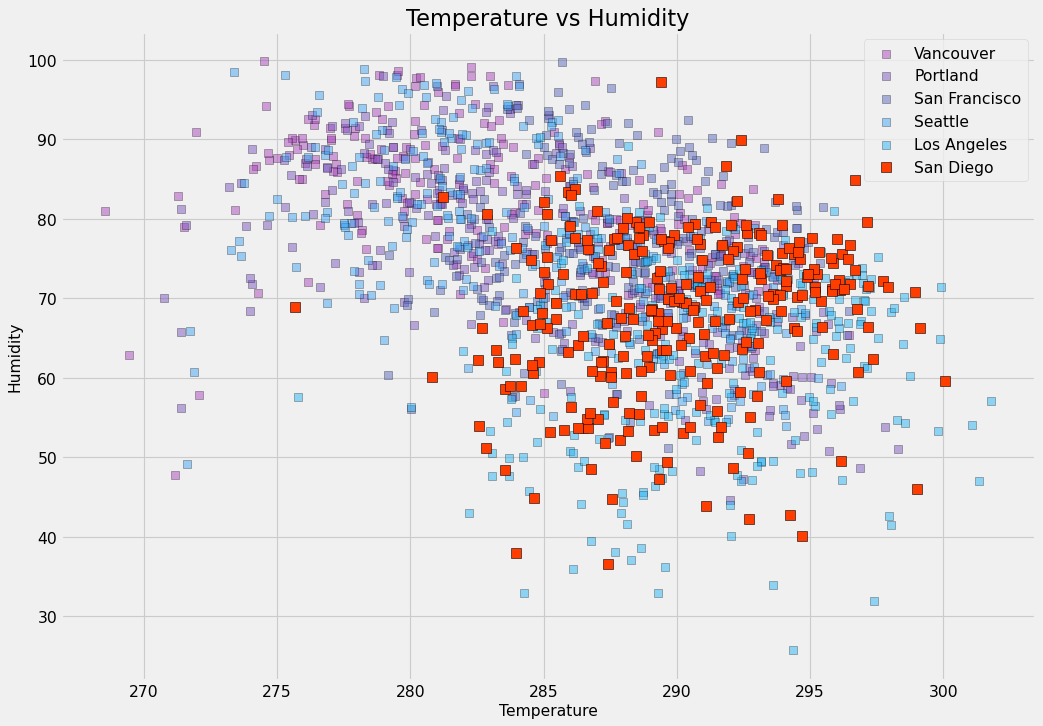

In [12]:
weather_scatter(n1='Temperature', n2='Humidity', dict1=temp_dict, dict2=humidity_dict)

Difficult to see what city is similar... we can rely on the below methods:

### Distance between centroids?

* Cosine similarity
* Covariance matrices
* MAPE - mean absolute percentage error
* ARIMA model - compare coefficients and use distance metric on those

* distinct covariance matrices
* covariance matrix with all vectors 

### Generate Correlation Matrices on all data sets individually

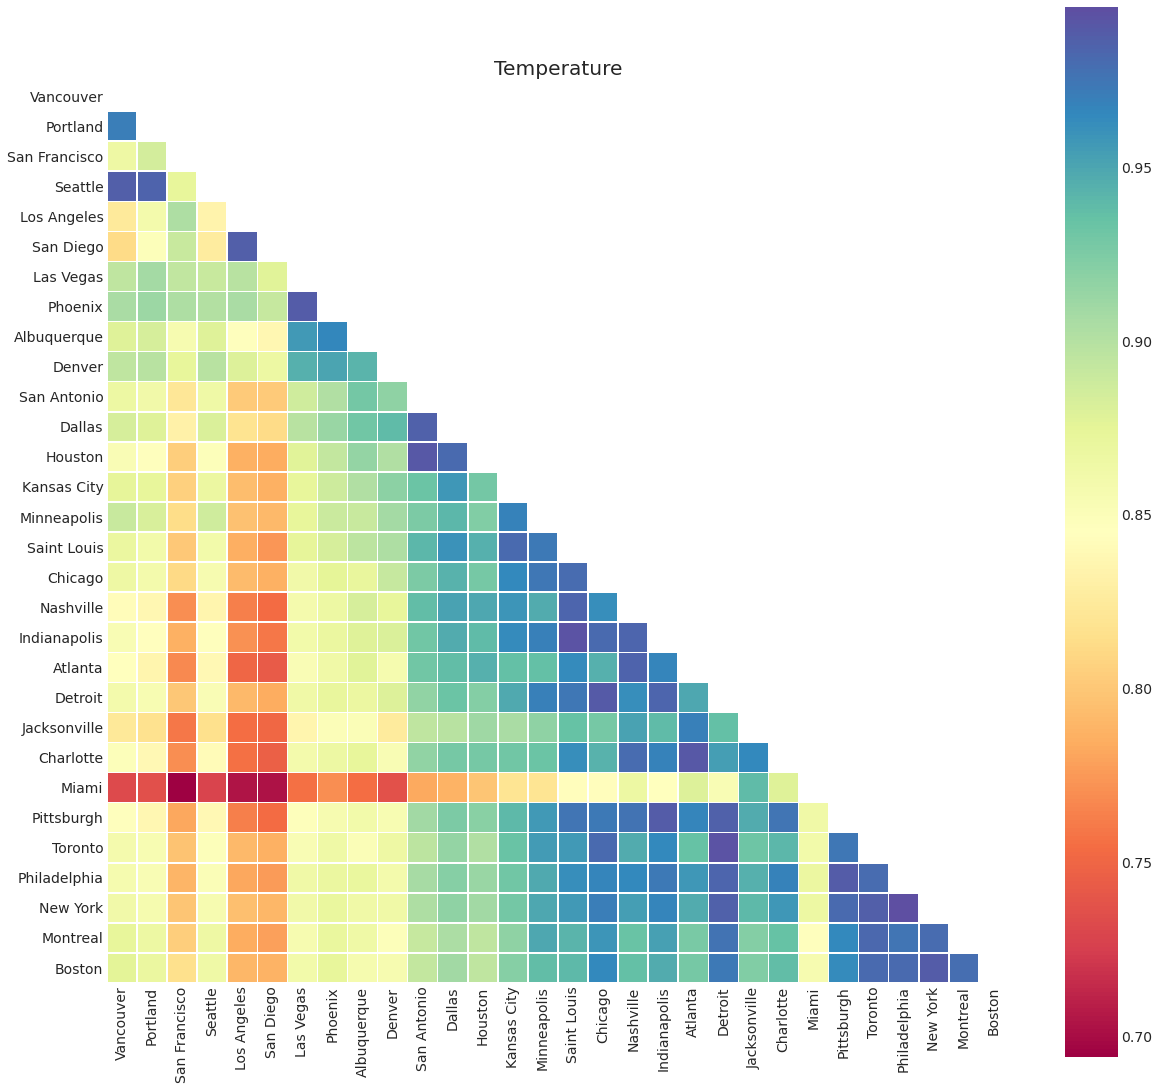

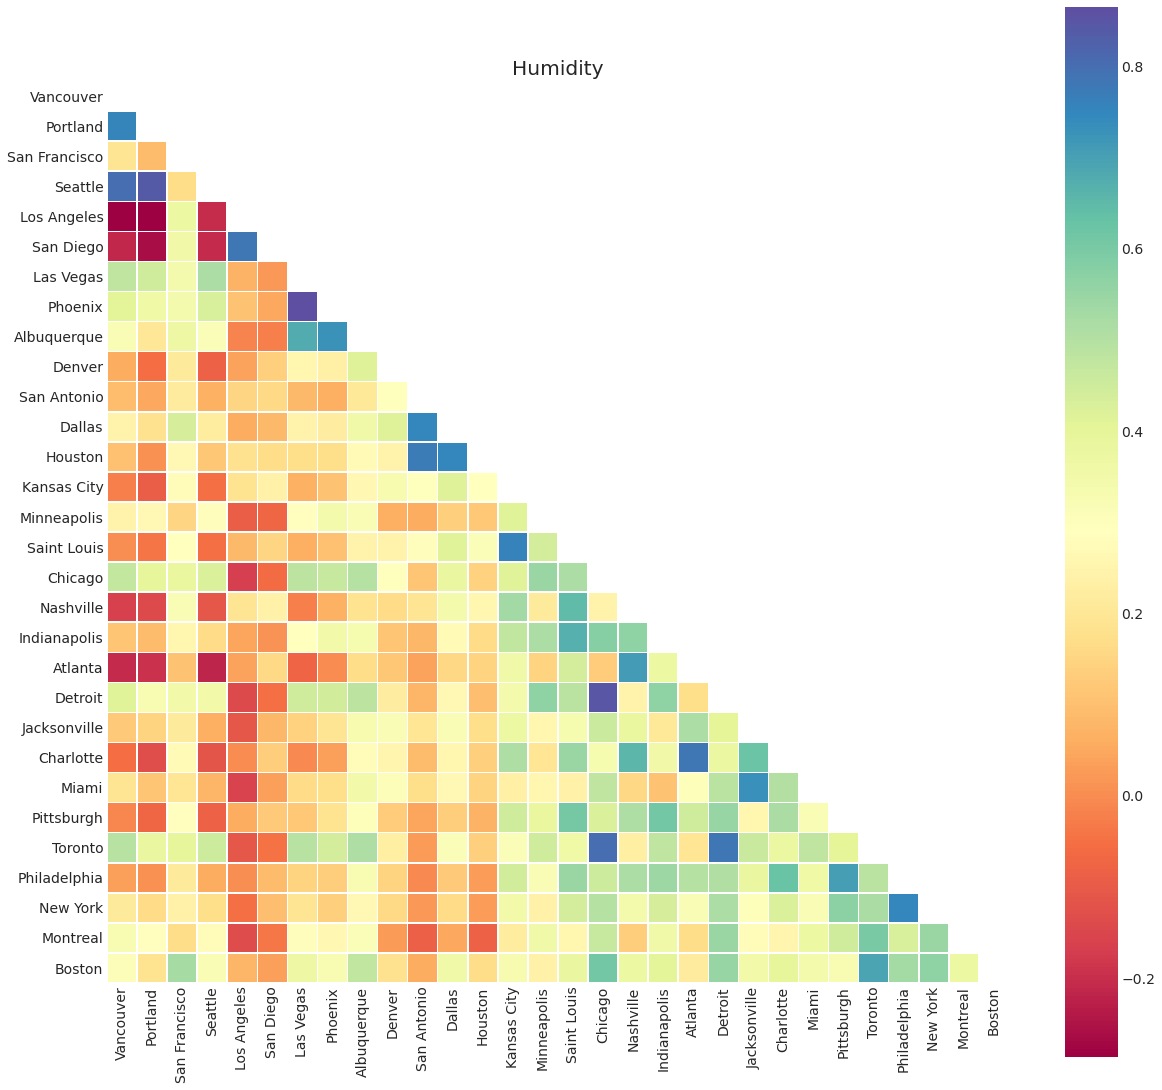

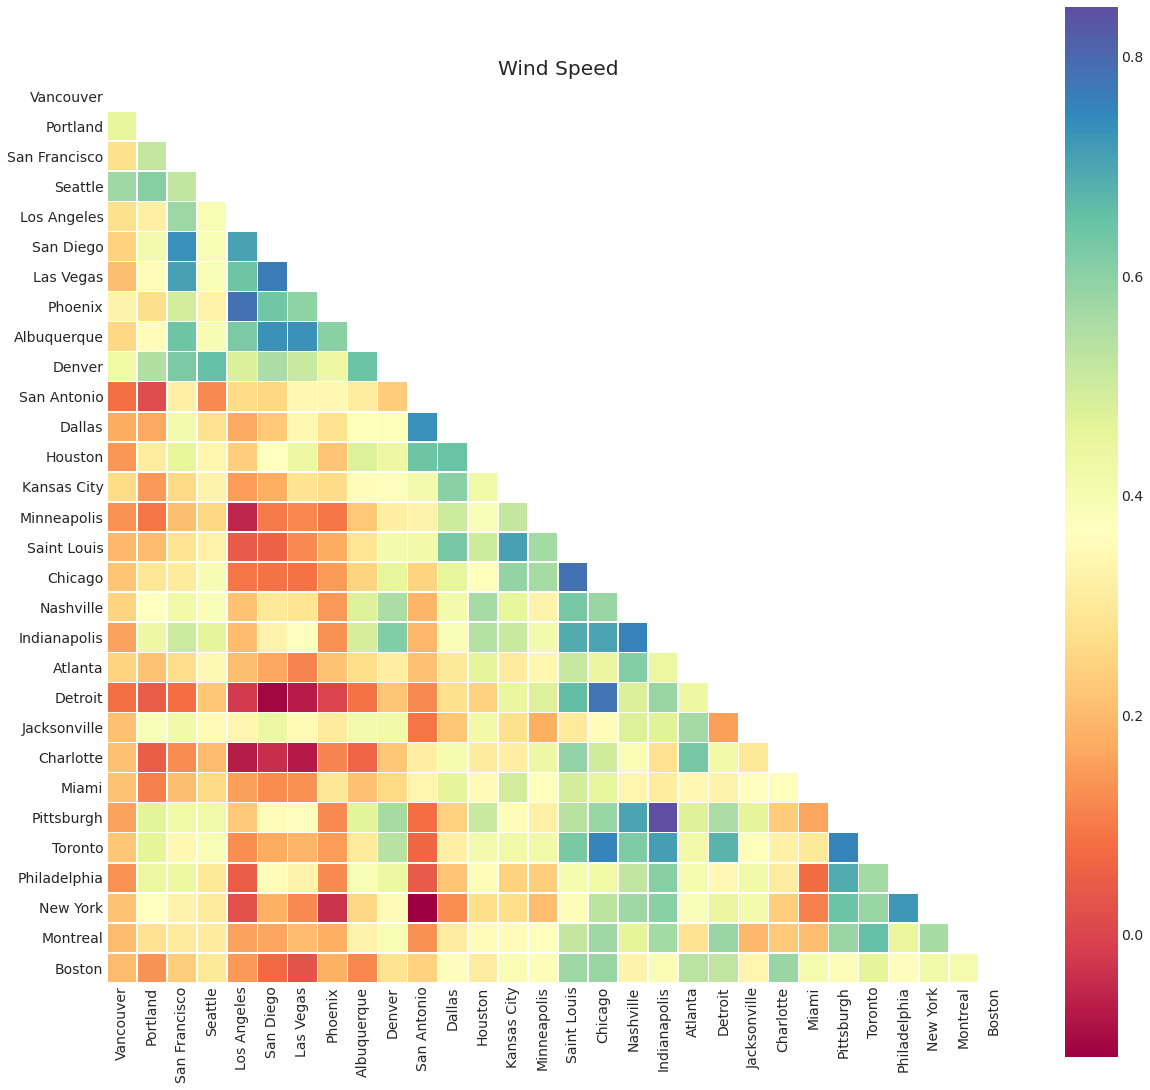

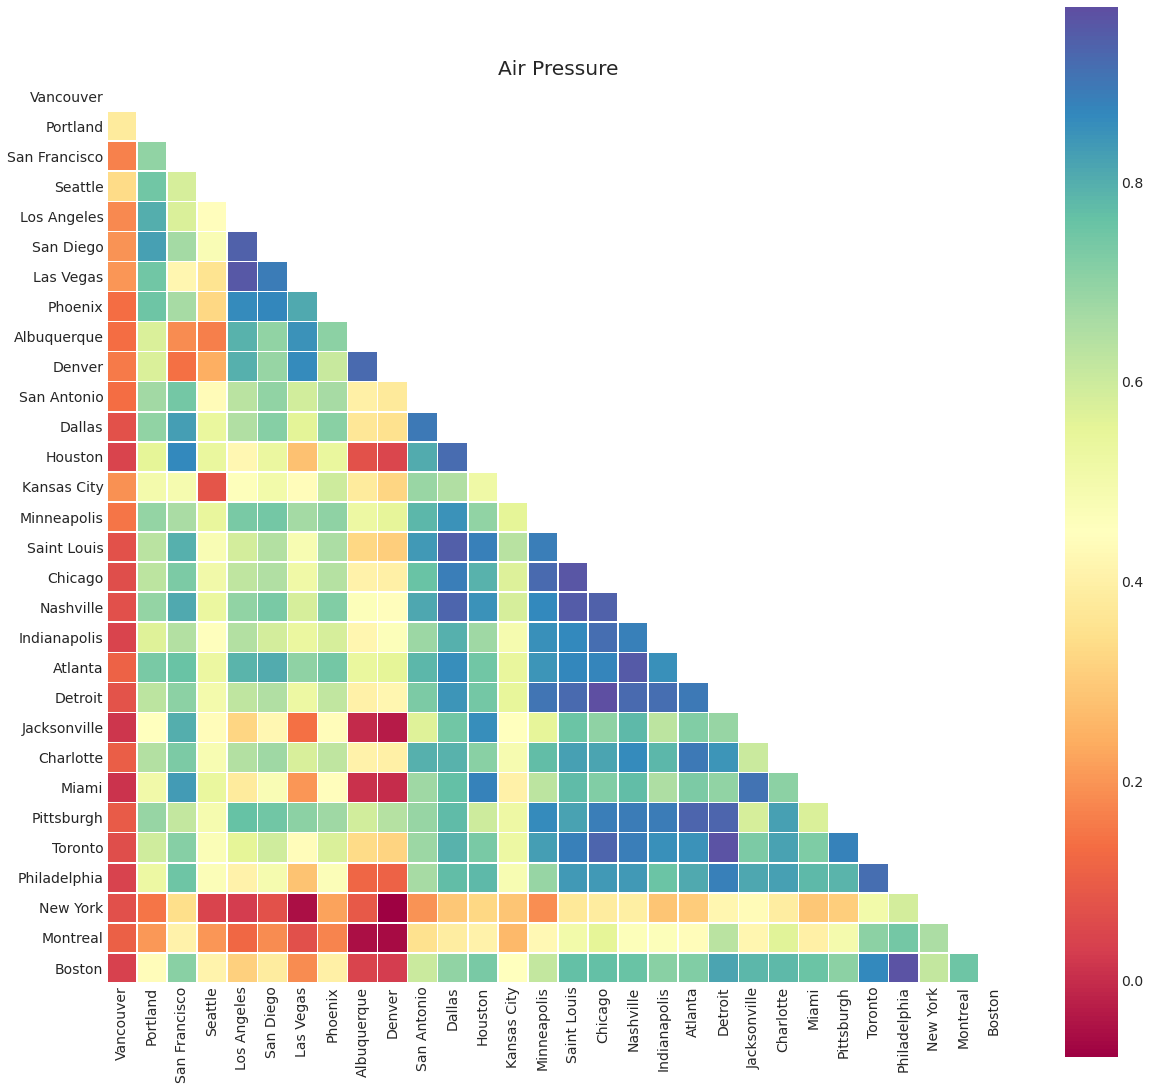

In [13]:
for name, df in {'Temperature': wd.temperature, 'Humidity': wd.humidity, 'Wind Speed': wd.wind_speed, 'Air Pressure': wd.air_pressure}.items():
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(18, 18))
        ax = sns.heatmap(corr, mask=mask, square=True, cmap="Spectral", linewidths=.5).set_title(name)

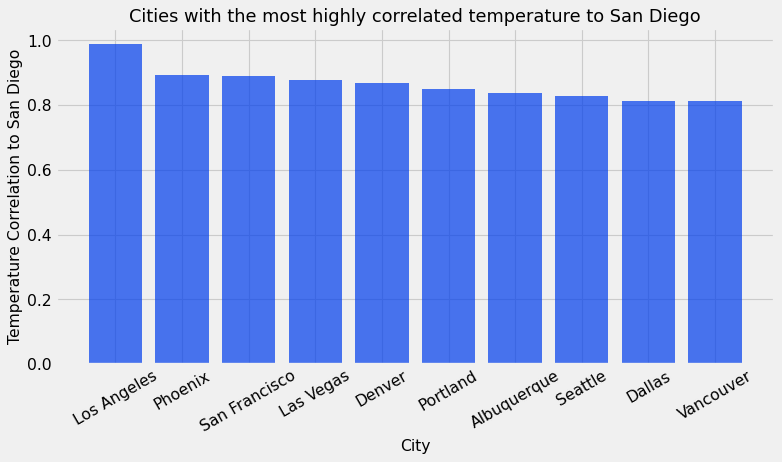

In [14]:
cities_to_plot: int = 10

sorted_temp_corrs = wd.temperature.corr()['San Diego'].sort_values(ascending=False)[1:cities_to_plot+1]

figure(figsize=(10, 6), dpi=80)
plt.bar(sorted_temp_corrs.index, sorted_temp_corrs, align='center', alpha=0.5)

opacity = 0.4
bar_width = 0.35

plt.xlabel('City')
plt.ylabel('Temperature Correlation to San Diego')
plt.title(f'Cities with the most highly correlated temperature to San Diego')

plt.xticks(range(len(sorted_temp_corrs)), (sorted_temp_corrs.index), rotation=30)
bar1 = plt.bar(sorted_temp_corrs.index, sorted_temp_corrs, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('Temperature Correlation to San Diego', fontsize=14)
plt.title(f'Cities with the most highly correlated temperature to San Diego', fontsize=16)
plt.tight_layout()
plt.show()

At this point we know that relying on correlation or covariance isn't enough! So let's write a function that finds the actual distance or similarity between one column vector and each other column vector in the same matrix. This function should be able to take distance metrics such as RMSE, MAE, MAPE, etc. and should return a matrix of the same dimensions containing the error between each column and all other columns. This is similar to a correlation matrix, but instead of correlation between each column vector, we will find the distance (according to some metric) between each column vector. 

Cosine similarity should also be investigated here. 

#### Remember to normalize!! 

In [15]:
def make_error_df(df: pd.DataFrame, error_type: str) -> pd.DataFrame: 
    
    df.dropna(inplace=True)
    
    assert error_type in ('rmse', 'mse', 'mae', 'dtw'), f'error_type must be \'rmse\', \'mse\', or \'mae\', not {error_type}.'
    if error_type == 'rmse':
        squared = False
    else:
        squared = True
    
    rmse_dict = {}

    for i, col in enumerate(df.iteritems()):

        error_list = []

        for j, sub_col in enumerate(df.iteritems()):
            df.dropna()
            # use dynamic time warping
            if error_type == 'dtw':
                error: float = dtw.distance(col[1].tolist(), sub_col[1].tolist())
            else:
                error: float = round(mean_squared_error(col[1].tolist(), sub_col[1].tolist(), squared=squared), 6) 
                
            error_list.append(error)

        rmse_dict[col[0]] = error_list
        
    df = pd.DataFrame.from_dict(rmse_dict)
    df.index = df.columns

    return df


In [16]:
# DEFINE ERROR TYPE
error_type = 'rmse'

CPU times: user 5.1 s, sys: 136 ms, total: 5.24 s
Wall time: 5.27 s


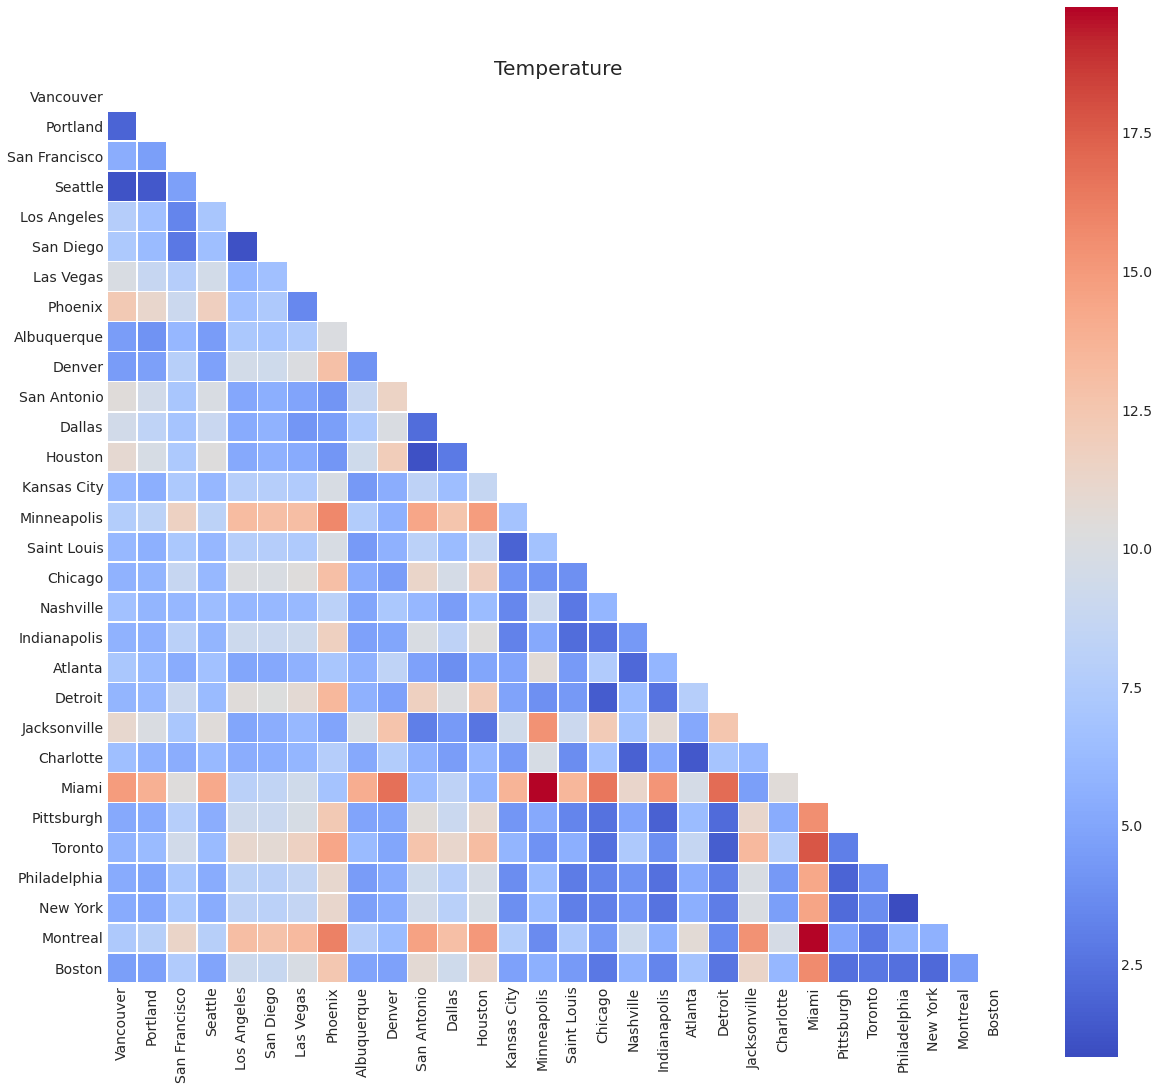

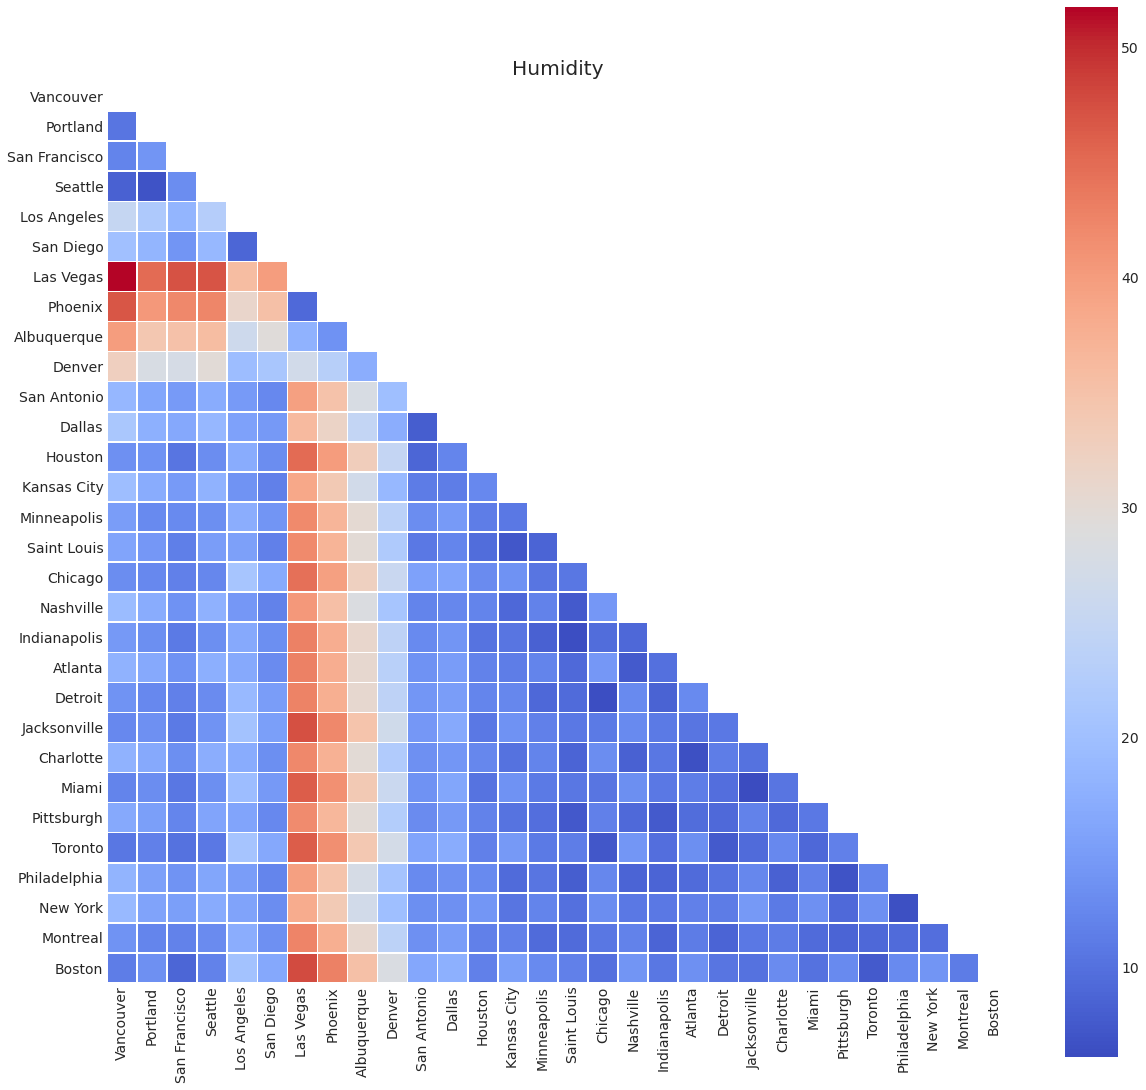

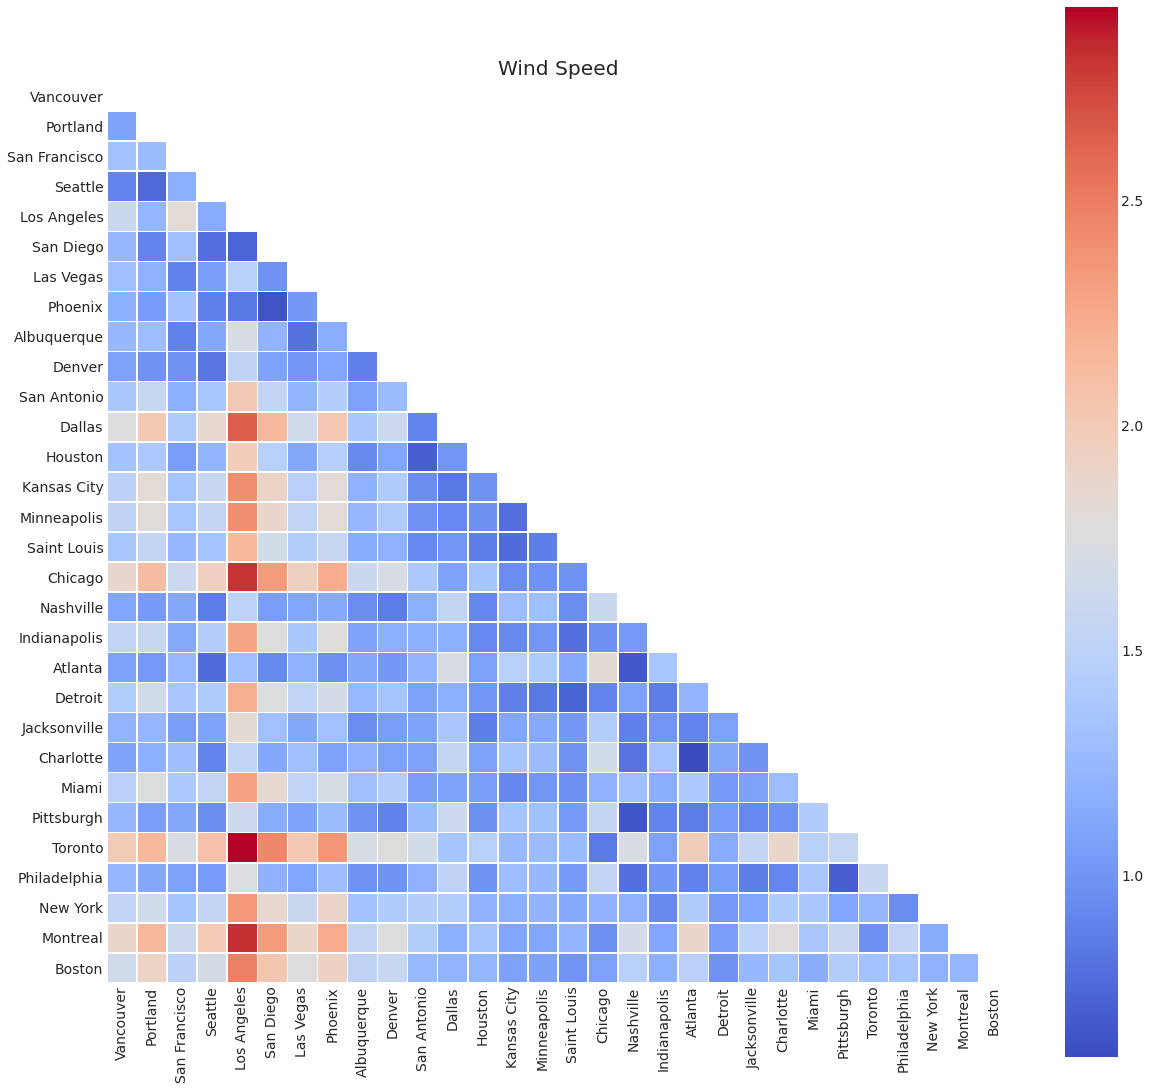

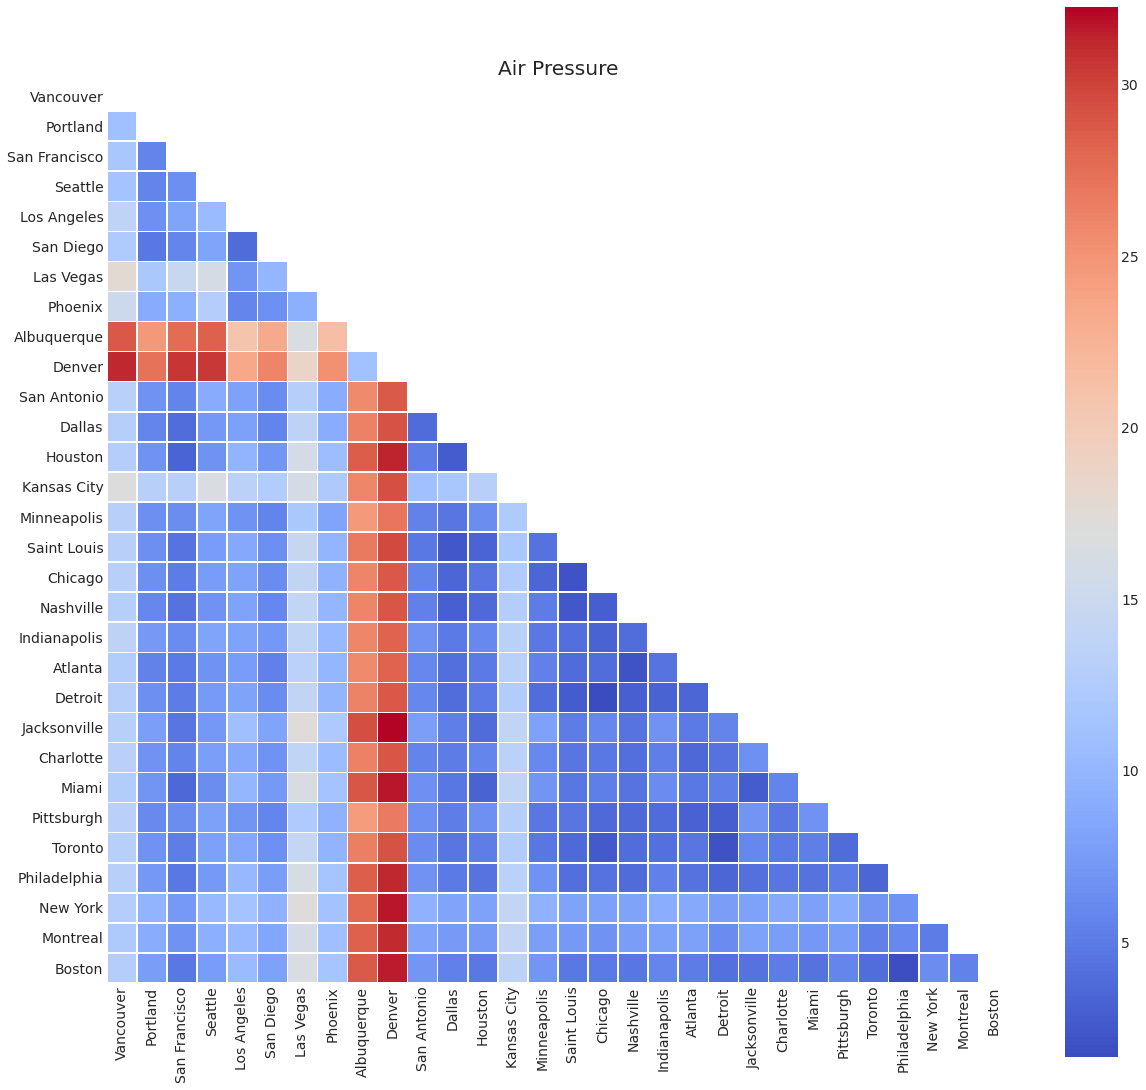

In [17]:
%%time
for name, df in {'Temperature': wd.temperature, 
                 'Humidity': wd.humidity, 
                 'Wind Speed': wd.wind_speed, 
                 'Air Pressure': wd.air_pressure}.items():
    # remove the last row of the df becasue some rows contain NaNs
    error_df = make_error_df(df=df.iloc[:-1, :], error_type=error_type)
    mask = np.zeros_like(error_df)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(18, 18))
        ax = sns.heatmap(error_df, mask=mask, square=True, cmap="coolwarm", linewidths=.5).set_title(name)

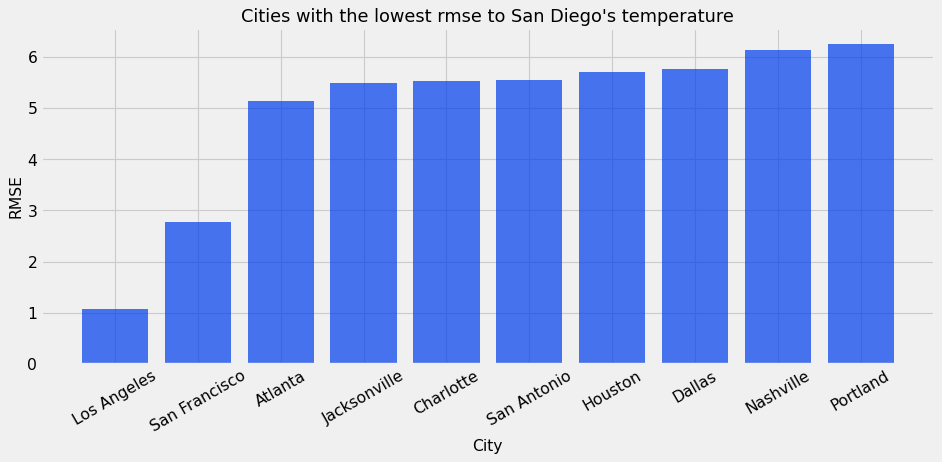

In [18]:
cities_to_plot: int = 10

sorted_temp_rmse = make_error_df(df=wd.temperature.iloc[:-1, :], error_type='rmse')['San Diego'].sort_values(ascending=True)[1:cities_to_plot+1]

figure(figsize=(12, 6), dpi=80)
plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=0.5)

opacity = 0.4
bar_width = 0.35

plt.xlabel('City')
plt.ylabel('Temperature Correlation to San Diego')
plt.title(f'Cities with the most highly correlated temperature to San Diego')

plt.xticks(range(len(sorted_temp_rmse)), (sorted_temp_rmse.index), rotation=30)
bar1 = plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title(f'Cities with the lowest {error_type} to San Diego\'s temperature', fontsize=16)
plt.tight_layout()
plt.show()

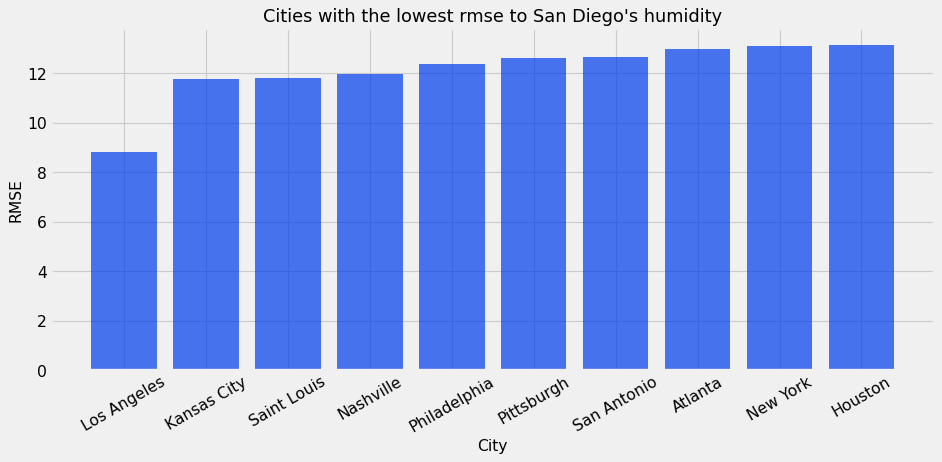

In [19]:
cities_to_plot: int = 10

sorted_temp_rmse = make_error_df(df=wd.humidity.iloc[:-1, :], error_type='rmse')['San Diego'].sort_values(ascending=True)[1:cities_to_plot+1]

figure(figsize=(12, 6), dpi=80)
plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=0.5)

opacity = 0.4
bar_width = 0.35

plt.xticks(range(len(sorted_temp_rmse)), (sorted_temp_rmse.index), rotation=30)
bar1 = plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title(f'Cities with the lowest {error_type} to San Diego\'s humidity', fontsize=16)
plt.tight_layout()
plt.show()

### Load housing price dataset for all large american cities

In [20]:
housing_url: str = 'https://www.kiplinger.com/article/real-estate/t010-c000-s002-home-price-changes-in-the-100-largest-metro-areas.html'
dfs = pd.read_html(housing_url)
housing_prices = dfs[0]

In [21]:
housing_prices[['Metro Area', 'Median Home Price']]

Metro Area Median Home Price
0                Akron, Ohio          $150,000
1               Albany, N.Y.            215000
2          Albuquerque, N.M.            180000
3               Atlanta, Ga.            250000
4               Augusta, Ga.            169000
..                       ...               ...
95              Tulsa, Okla.            169000
96       Virginia Beach, Va.            250000
97  Washington, D.C.-No. Va.            435000
98       Winston-Salem, N.C.            165000
99          Worcester, Mass.            260000

[100 rows x 2 columns]

### Look at the mean housing prices for all cities similar to San Diego weather

In [22]:
# TODO create bubble chart
df = px.data.gapminder()

fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp",
size="pop", color="continent",
hover_name="country", log_x=True, size_max=60)
fig.show()

### Display the similar cities with the least expensive houses 